# Data Analysis

This notebook performs the following steps:
1. Data analysis of HGG DB
2. Data analysis of PLGG in relation to HGG
3. Data analysis of both DBs

1. Data analysis of HGG DB:
The goal is to understand the main characteristics of HGG tumor.


In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re

# Set basic plot parameters
plt.rcParams['figure.figsize'] = (10, 6)

# Load the cleaned dataset
df = pd.read_csv('../data/processed/HGG_DB_cleaned.csv')

# Display a preview to confirm loading
print("Dataset loaded successfully. First 5 rows:")
print(df.head())

Dataset loaded successfully. First 5 rows:
       sample dipgnbshgg location tumor_grade 3_yrs  acvr1  histone3    atrx  \
0  SJHGG059_A       DIPG  midline          IV    No  G328V       NaN     NaN   
1  SJHGG064_A       DIPG  midline          IV    No  G328W       NaN     NaN   
2  SJHGG071_A       DIPG  midline         NaN    No  G328E       NaN  T1610R   
3  SJHGG005_A       DIPG  midline          IV    No  G328V       NaN     NaN   
4  SJHGG106_A       DIPG  midline          IV    No  R258G  H3.1K27M     NaN   

  bcor bcorl1  ... ntrk123 egfr  pik3ca       pik3r1 braf  nf1 ccnd123cdk46  \
0  NaN    NaN  ...     NaN  NaN   E545K  T576_R577>R  NaN  NaN          NaN   
1  NaN    NaN  ...     NaN  NaN  H1047R          NaN  NaN  NaN          NaN   
2  NaN    NaN  ...     NaN  NaN   E545K          NaN  NaN  NaN          NaN   
3  NaN    NaN  ...     NaN  NaN     NaN          NaN  NaN  NaN          NaN   
4  NaN    NaN  ...     NaN  NaN  H1047R          NaN  NaN  NaN          NaN   

 

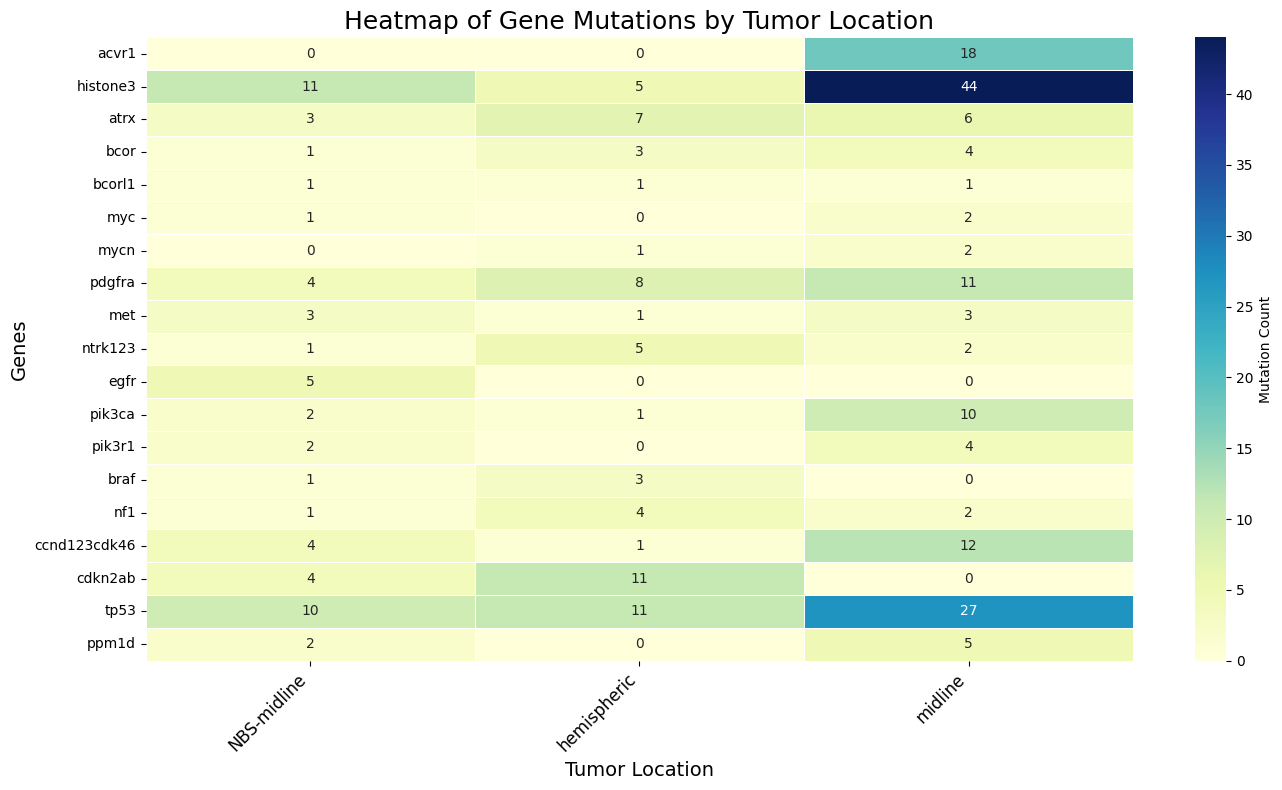

Top 5 Genes with Most Mutations by Tumor Location:


location,NBS-midline,hemispheric,midline
acvr1,0,0,18
atrx,0,7,0
ccnd123cdk46,4,0,12
cdkn2ab,0,11,0
egfr,5,0,0
histone3,11,5,44
pdgfra,4,8,11
tp53,10,11,27


C:\Users\aviga\AppData\Local\Temp\ipykernel_6852\918597668.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


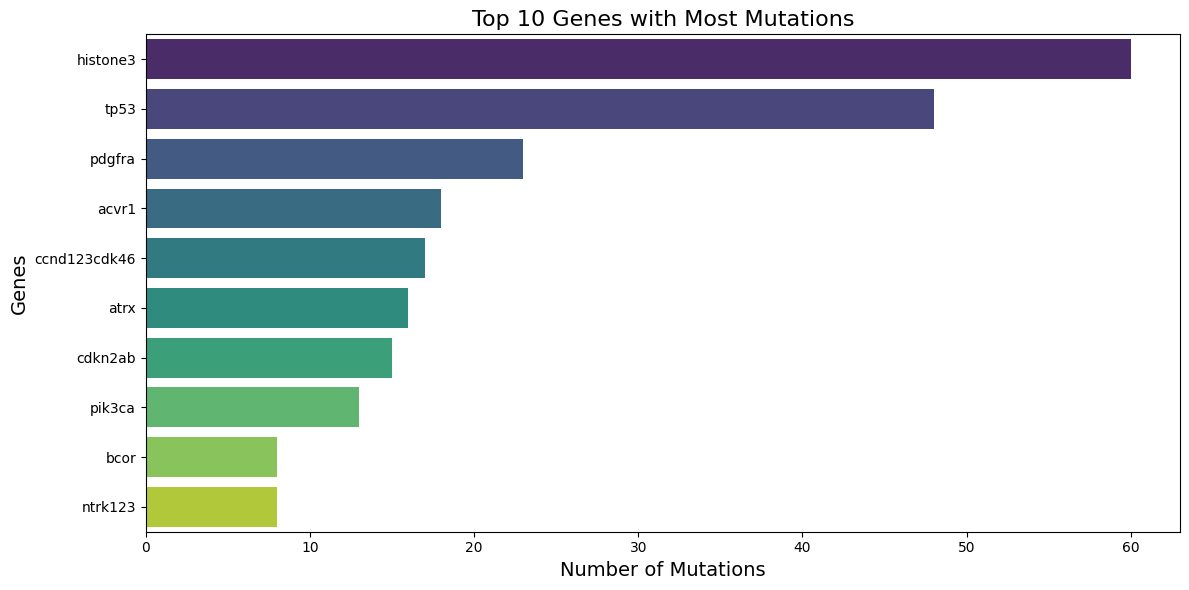

In [246]:


# Load our cleaned dataset
data = pd.read_csv('../data/processed/HGG_DB_cleaned.csv')

# Preprocess the data: Count mutations per gene for each location
mutation_columns = data.columns[5:]  # Assuming gene columns start from index 5
data["Total Mutations"] = data[mutation_columns].notna().sum(axis=1)  # Count non-NaN values for mutations

# Group by location and calculate mutation counts for each gene
mutation_by_location = data.groupby("location")[mutation_columns].apply(lambda x: x.notna().sum()).T

# Create a heatmap of mutation counts by location and gene
plt.figure(figsize=(14, 8))
sns.heatmap(
    mutation_by_location,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Mutation Count"}
)

# Customize the plot
plt.title("Heatmap of Gene Mutations by Tumor Location", fontsize=18)
plt.xlabel("Tumor Location", fontsize=14)
plt.ylabel("Genes", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Find the top 5 genes with the most mutations for each tumor location
top_genes_per_location = (
    mutation_by_location
    .apply(lambda x: x.nlargest(5))  # Select the top 5 genes for each location
    .fillna(0)  # Fill missing values with 0 for better display
    .astype(int)  # Convert to integer for readability
)

# Display the top genes
print("Top 5 Genes with Most Mutations by Tumor Location:")
display(top_genes_per_location)  

# Save the top genes table to a CSV file
top_genes_output_path = "../data/processed/HGG_top_genes_by_location.csv"
top_genes_per_location.to_csv(top_genes_output_path)

# ----------------------------------------------------
# Create a bar plot for the top 10 genes with most mutations overall
# ----------------------------------------------------

# Step 1: Calculate total mutations for each gene across all locations
total_mutations_per_gene = mutation_by_location.sum(axis=1).sort_values(ascending=False)

# Step 2: Select the top 10 genes with the most mutations
top_10_genes = total_mutations_per_gene.head(10)

# Step 3: Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_10_genes.values, 
    y=top_10_genes.index, 
    palette="viridis"
)
plt.title("Top 10 Genes with Most Mutations", fontsize=16)
plt.xlabel("Number of Mutations", fontsize=14)
plt.ylabel("Genes", fontsize=14)
plt.tight_layout()


plt.show()




B. Classification of HGG genes
We wanted to know if the genes can be listed or grouped into potential functional or biological classes based on their roles in pathways or processes. so we looked at the litreture and found that the genes are classified into some classes


FunctionalClass(name=Chromatin and Transcription Regulation, genes=['histone3', 'atrx', 'bcor', 'bcorl1'])
FunctionalClass(name=RTK-RAS-PI3K Pathway, genes=['pdgfra', 'met', 'ntrk123', 'egfr', 'pik3ca', 'pik3r1', 'braf', 'myc', 'mycn'])
FunctionalClass(name=RB1 and TP53 Pathways, genes=['nf1', 'ccnd123cdk46', 'cdkn2ab', 'tp53', 'ppm1d'])
FunctionalClass(name=Other Tumor Drivers, genes=['acvr1'])


C:\Users\aviga\AppData\Local\Temp\ipykernel_6852\1603936613.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gene_counts, y=class_names, palette="viridis")


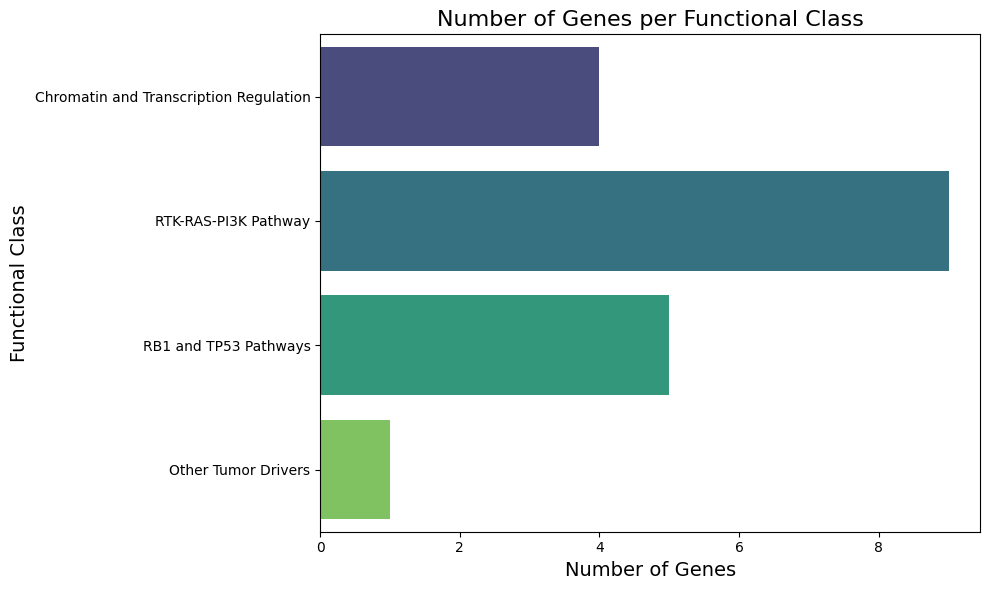

In [247]:
import seaborn as sns

# Define a class for genes
class Gene:
    def __init__(self, name, functional_class=None):
        self.name = name
        self.functional_class = functional_class

    def __repr__(self):
        return f"Gene(name={self.name}, functional_class={self.functional_class})"

# Define a class for functional classes
class FunctionalClass:
    def __init__(self, name):
        self.name = name
        self.genes = []  # List of Gene objects

    def add_gene(self, gene):
        self.genes.append(gene)

    def __repr__(self):
        return f"FunctionalClass(name={self.name}, genes={[gene.name for gene in self.genes]})"

# Step 1: Load the Classes file
classes_file_path = r"../data/raw/Classes.organized.csv"
classes_table = pd.read_csv(classes_file_path)

# Step 2: Create FunctionalClass objects and map genes to them
functional_classes = {}

for _, row in classes_table.iterrows():
    functional_class_name = row["Functional Class"]
    genes = row.drop("Functional Class").dropna()  # Extract all genes in this functional class

    # Create a FunctionalClass object if it doesn't exist
    if functional_class_name not in functional_classes:
        functional_classes[functional_class_name] = FunctionalClass(functional_class_name)

    # Add genes to the FunctionalClass
    for gene_name in genes:
        gene = Gene(name=gene_name, functional_class=functional_class_name)
        functional_classes[functional_class_name].add_gene(gene)

# Step 3: Display the FunctionalClass objects
for fc_name, fc_object in functional_classes.items():
    print(fc_object)


# Prepare data for plotting
class_counts = {fc_name: len(fc_object.genes) for fc_name, fc_object in functional_classes.items()}
class_names = list(class_counts.keys())
gene_counts = list(class_counts.values())

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=gene_counts, y=class_names, palette="viridis")
plt.title("Number of Genes per Functional Class", fontsize=16)
plt.xlabel("Number of Genes", fontsize=14)
plt.ylabel("Functional Class", fontsize=14)
plt.tight_layout()
plt.show()


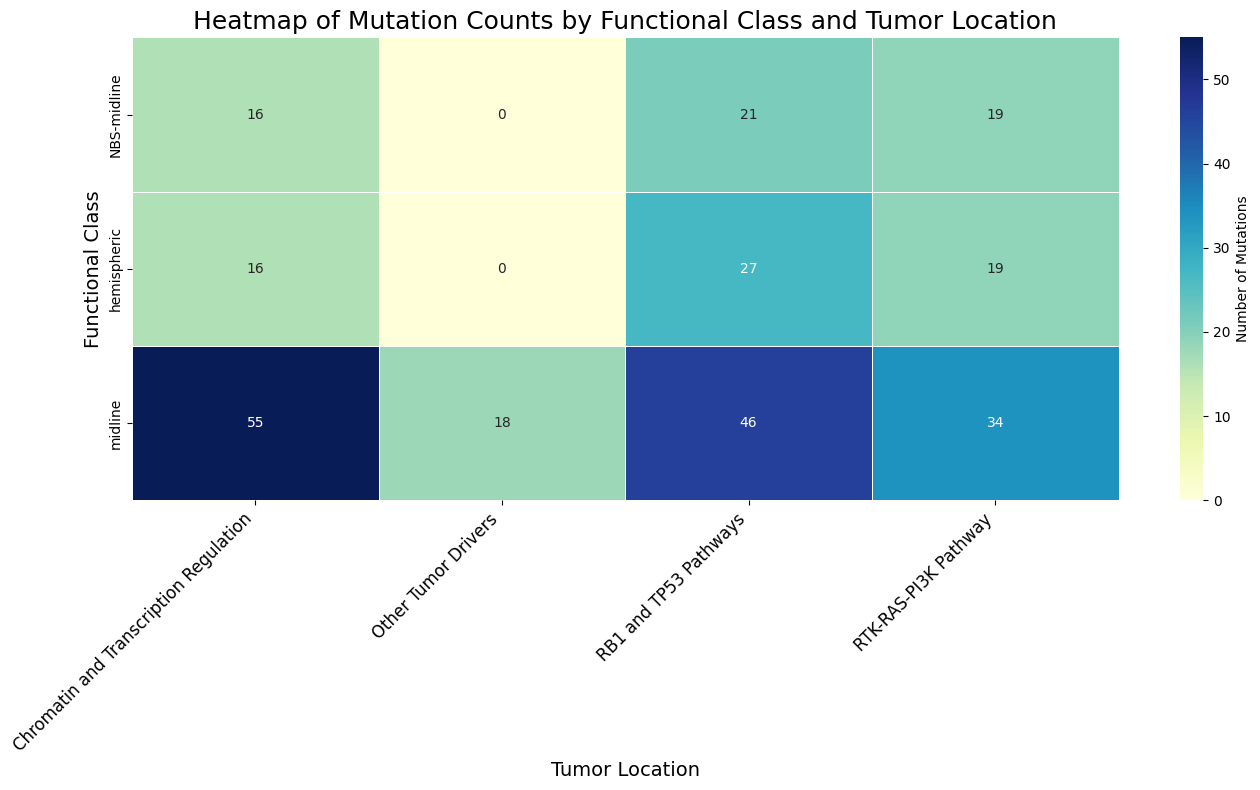

In [248]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
db_file_path = r"../data/processed/HGG_DB_cleaned.csv"
classes_file_path = r"../data/raw/Classes.organized.csv"

db_table = pd.read_csv(db_file_path)
classes_table = pd.read_csv(classes_file_path)

# Step 1: Create a mapping of genes to functional classes
gene_to_class = {}
for _, row in classes_table.iterrows():
    functional_class = row["Functional Class"]
    genes = row.drop("Functional Class").dropna()
    for gene in genes:
        gene_to_class[gene.strip()] = functional_class

# Step 2: Identify gene columns in the HGG table
gene_columns = db_table.columns[5:]  # Assuming gene columns start at index 5

# Step 3: Melt the HGG table to long format for analysis
db_table_melted = db_table.melt(
    id_vars=["location"],  # Keep location column
    value_vars=gene_columns,  # Gene columns
    var_name="Gene",  # New column for gene names
    value_name="Mutation Value"  # New column for mutation values
)

# Step 4: Map Functional Class to each gene
db_table_melted["Gene"] = db_table_melted["Gene"].str.strip()  # Strip extra spaces
db_table_melted["Functional Class"] = db_table_melted["Gene"].map(gene_to_class)

# Step 5: Drop rows where Functional Class is not defined
db_table_melted = db_table_melted.dropna(subset=["Functional Class"])

# Step 6: Count mutations for each Functional Class and location
db_table_melted["Mutation Value"] = db_table_melted["Mutation Value"].fillna("None")  # Replace NaN with "None"
mutation_counts = (
    db_table_melted.groupby(["location", "Functional Class"])["Mutation Value"]
    .apply(lambda x: (x != "None").sum())  # Count non-"None" mutations
    .unstack(fill_value=0)  # Pivot table for heatmap
)

# Step 7: Plot the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    mutation_counts,
    annot=True,
    fmt="d",  # Show integer counts
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Number of Mutations"}
)
plt.title("Heatmap of Mutation Counts by Functional Class and Tumor Location", fontsize=18)
plt.xlabel("Tumor Location", fontsize=14)
plt.ylabel("Functional Class", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.tight_layout()
plt.show()


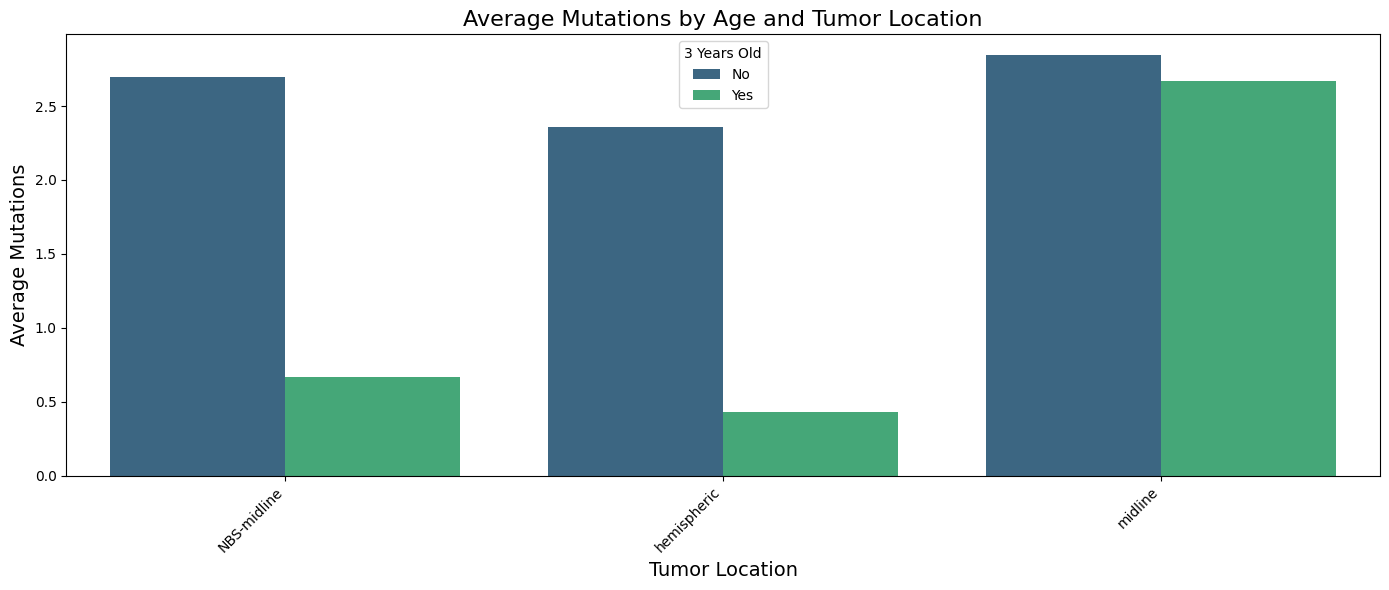

In [249]:
# Group by age (3_yrs) and calculate mutation statistics
mutation_stats = data.groupby(["3_yrs", "location"])["Total Mutations"].mean().reset_index()

# Step 3: Create a bar plot to show average mutations by age and location
plt.figure(figsize=(14, 6))
sns.barplot(
    data=mutation_stats,
    x="location",
    y="Total Mutations",
    hue="3_yrs",
    palette="viridis"
)
plt.title("Average Mutations by Age and Tumor Location", fontsize=16)
plt.xlabel("Tumor Location", fontsize=14)
plt.ylabel("Average Mutations", fontsize=14)
plt.legend(title="3 Years Old")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



<Figure size 1200x800 with 0 Axes>

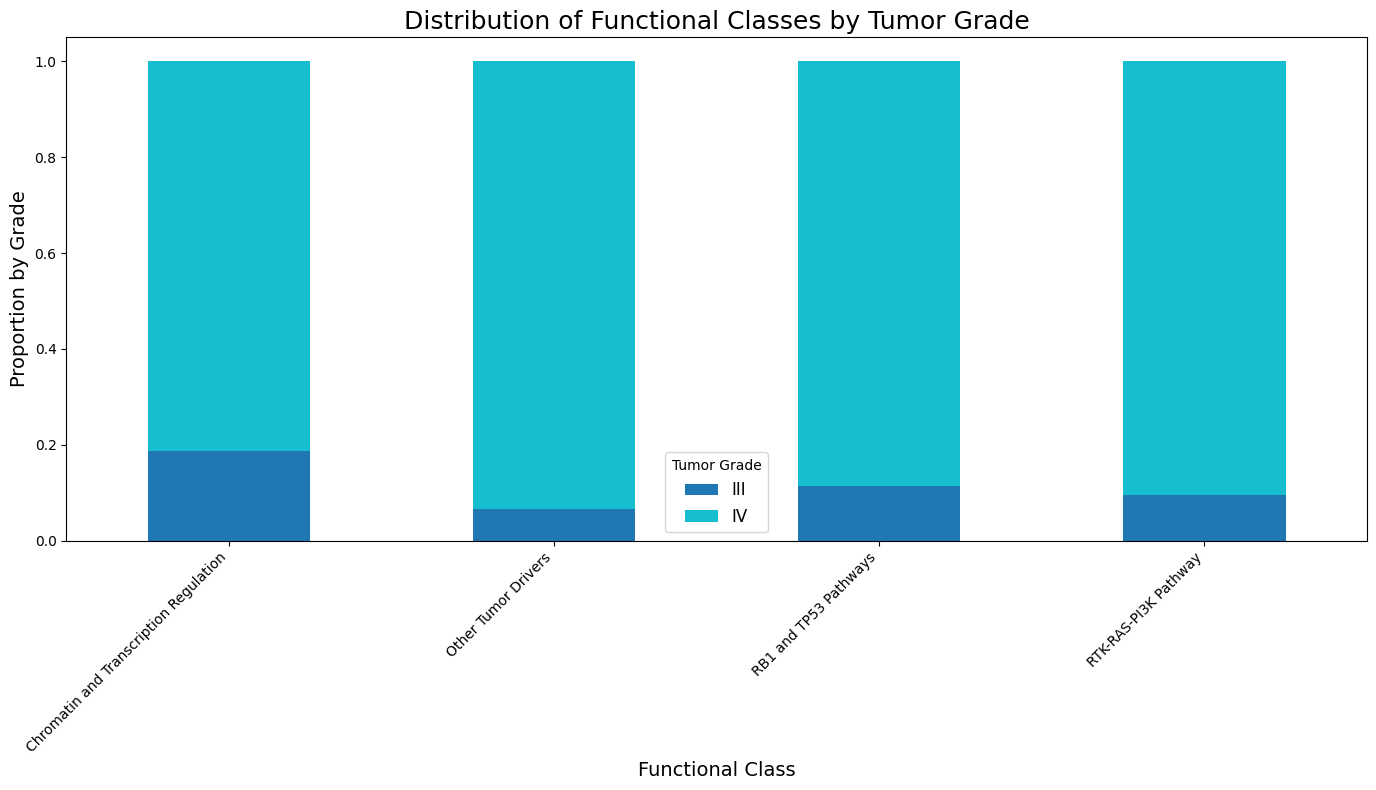

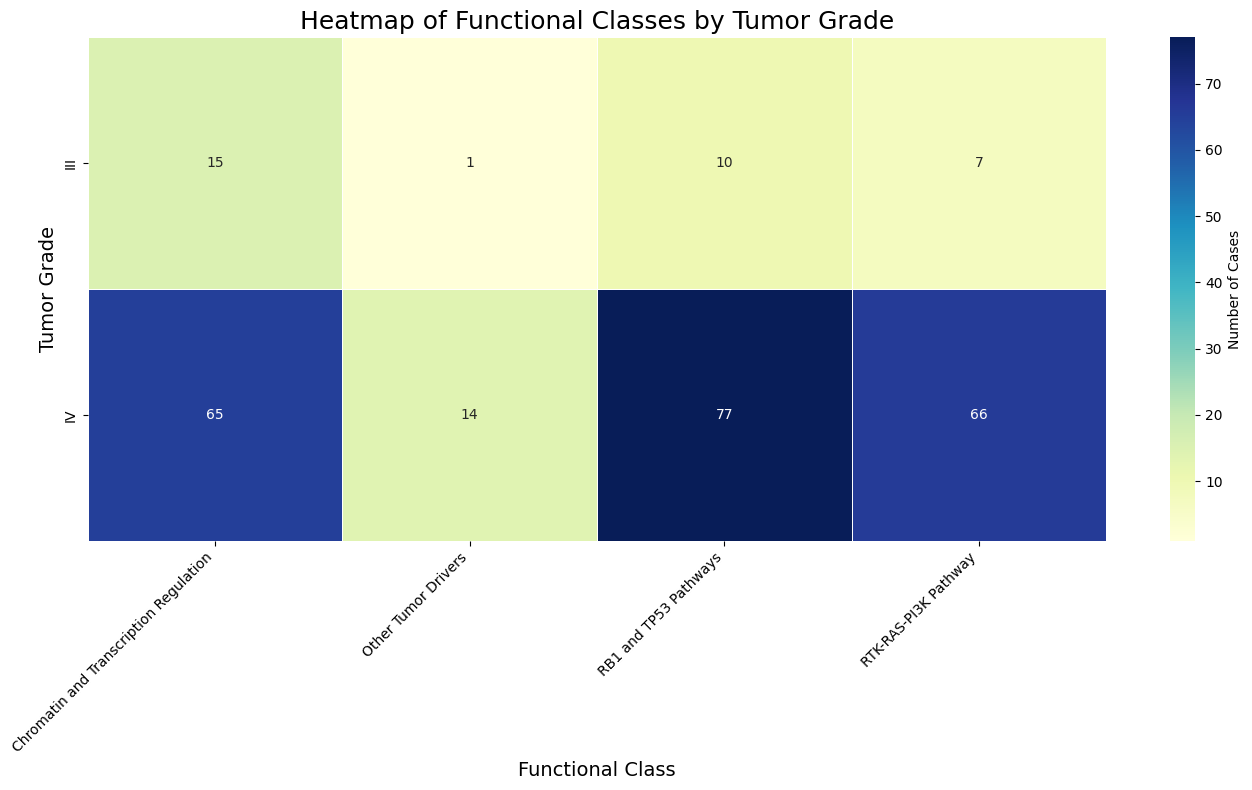

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
data_file_path = r"../data/processed/HGG_DB_cleaned.csv"
classes_file_path = r"../data/raw/Classes.organized.csv"

data = pd.read_csv(data_file_path)
classes = pd.read_csv(classes_file_path)

# Step 2: Map Functional Classes to the dataset
# Create a dictionary mapping genes to functional classes
gene_to_class = {}
for _, row in classes.iterrows():
    functional_class = row["Functional Class"]
    genes = row.drop("Functional Class").dropna()  # Get all genes for this functional class
    for gene in genes:
        gene_to_class[gene] = functional_class

# Add Functional Class column to the data
functional_class_columns = data.columns[5:]  # Assuming gene columns start from index 5
data["Functional Class"] = data[functional_class_columns].apply(
    lambda row: [gene_to_class[gene] for gene in row.index if gene in gene_to_class and pd.notna(row[gene])],
    axis=1
)

# Explode the Functional Class column to handle multiple classes
data_exploded = data.explode("Functional Class")

# Step 3: Group data by tumor_grade and functional class
grade_class_counts = data_exploded.groupby(["tumor_grade", "Functional Class"]).size().unstack(fill_value=0)

# Step 4: Create a bar plot of Functional Classes by tumor grade
grade_class_counts_normalized = grade_class_counts.div(grade_class_counts.sum(axis=0), axis=1)

plt.figure(figsize=(12, 8))
grade_class_counts_normalized.T.plot(kind="bar", stacked=True, figsize=(14, 8), cmap="tab10")
plt.title("Distribution of Functional Classes by Tumor Grade", fontsize=18)
plt.xlabel("Functional Class", fontsize=14)
plt.ylabel("Proportion by Grade", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Tumor Grade", fontsize=12)
plt.tight_layout()
plt.show()

# Step 5: Create a heatmap to show the relationship between Functional Class and Tumor Grade
plt.figure(figsize=(14, 8))
sns.heatmap(
    grade_class_counts,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Number of Cases"}
)
plt.title("Heatmap of Functional Classes by Tumor Grade", fontsize=18)
plt.xlabel("Functional Class", fontsize=14)
plt.ylabel("Tumor Grade", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Rare Mutations

Rare Mutations (Frequency 1-2):
                  Mutation  Frequency
0             A451fs (LOH)        1.0
1                    A88fs        1.0
2    AMP;SV (DIP2C_PDGFRA)        1.0
3        Amp (CCND2, CDK4)        1.0
4          Amp;I843_M844>M        1.0
..                     ...        ...
107                  G356D        2.0
108              A529>15aa        2.0
109             Amp (CDK4)        2.0
110                  S241F        2.0
111                  R206H        2.0

[112 rows x 2 columns]


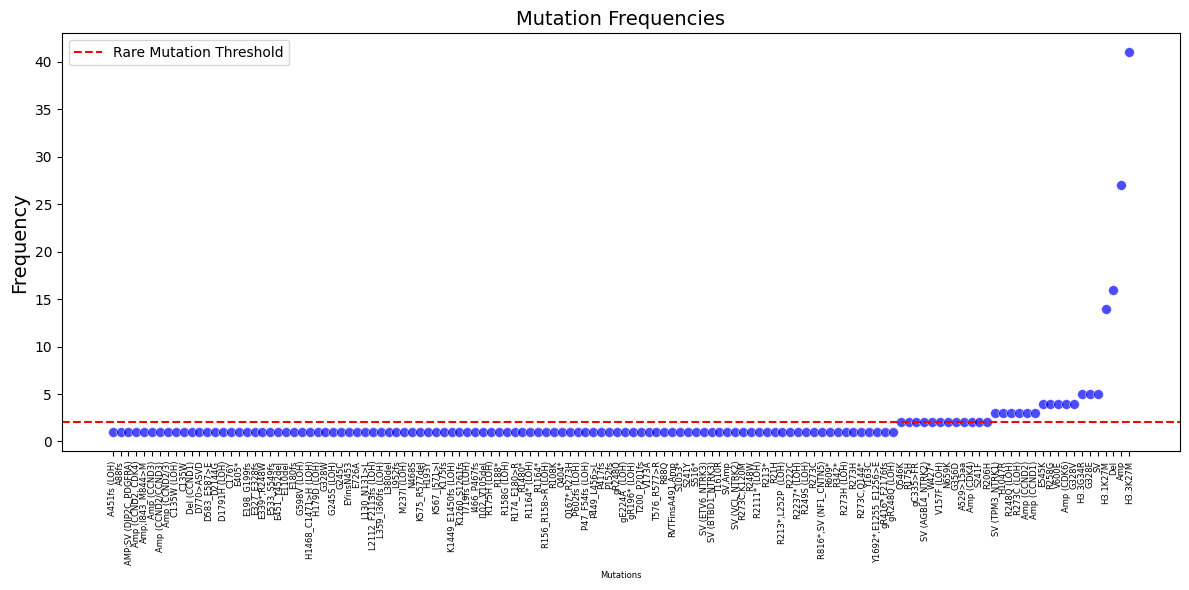

In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
data_file_path = r"../data/processed/HGG_DB_cleaned.csv"
data = pd.read_csv(data_file_path)

# Step 2: Extract mutation columns
mutation_columns = data.columns[5:]  # Assuming mutation columns start from index 5

# Step 3: Count the occurrence of each mutation
mutation_counts = data[mutation_columns].apply(pd.Series.value_counts).sum(axis=1).dropna().sort_values()

# Step 4: Filter rare mutations (1-2 occurrences)
rare_mutations = mutation_counts[mutation_counts <= 2]

# Step 5: Create a table of rare mutations
rare_mutations_table = rare_mutations.reset_index()
rare_mutations_table.columns = ["Mutation", "Frequency"]

# Display the table of rare mutations
print("Rare Mutations (Frequency 1-2):")
print(rare_mutations_table)

# Step 6: Save the rare mutations table to a CSV file
output_path = "../data/processed/rare_mutations.csv"
rare_mutations_table.to_csv(output_path, index=False)

# Step 7: Create a scatter plot of mutation frequencies
plt.figure(figsize=(12, 6))
plt.scatter(
    mutation_counts.index,
    mutation_counts.values,
    alpha=0.7,
    c="blue",
    edgecolors="w",
    linewidth=0.5,
    s=50
)
plt.axhline(2, color="red", linestyle="--", label="Rare Mutation Threshold")
plt.title("Mutation Frequencies", fontsize=14)
plt.xlabel("Mutations", fontsize=6)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()
